In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import scipy.special as sps
from scipy.stats import nakagami

## Nakagami Likelihood

In [3]:
omega=1.

In [4]:
h = nakagami.rvs(nu=4., size=10000)

In [5]:
def loglikelihood(m):
    return -(len(h) * (m *(np.log(m) - np.log(omega)) - np.log(sps.gamma(m)))
            - m *(np.sum(h ** 2) / omega - 2 * np.sum(np.log(h))))

In [6]:
m = np.linspace(1.01, 12., 100)

In [7]:
ll = loglikelihood(m)

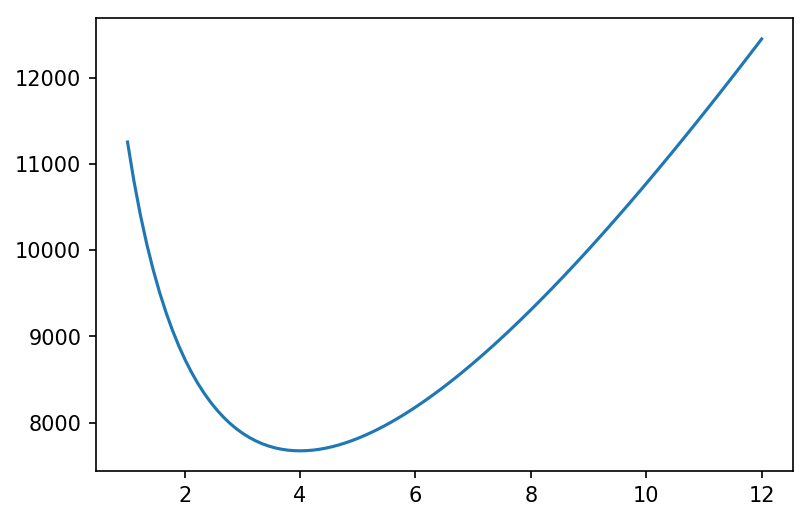

In [9]:
plt.plot(m, ll)

## Lower bound for $m * \log m$

In [13]:
xt = 1.5

In [14]:
x = np.linspace(.5, 5, 100)

In [16]:
dxlogx = x * (np.log(xt) + 1) - xt

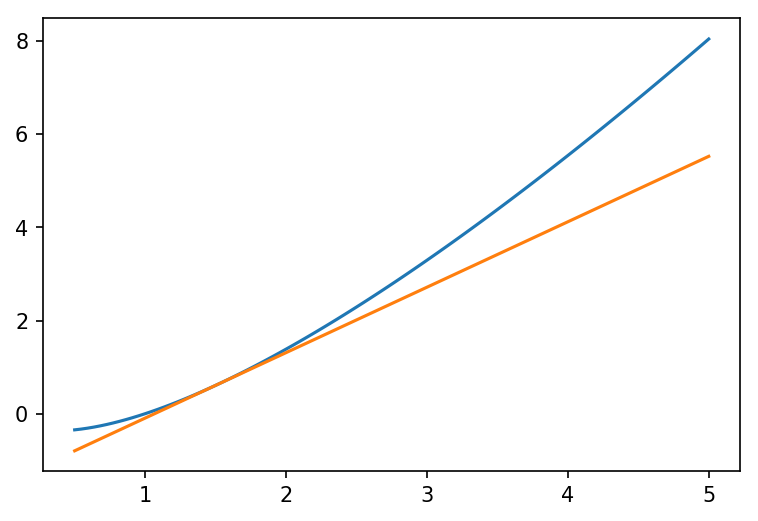

In [17]:
plt.plot(x, x * np.log(x))
plt.plot(x, dxlogx)

## Lower bound for $-\log\Gamma(m)$

In [18]:
f = np.log(sps.gamma(x))

In [21]:
p = sps.polygamma(1, x)

In [22]:
xt = 2.5

In [23]:
g = np.log(sps.gamma(xt)) + sps.digamma(xt) * (x - xt) + .5*p[0] * (x - xt) ** 2

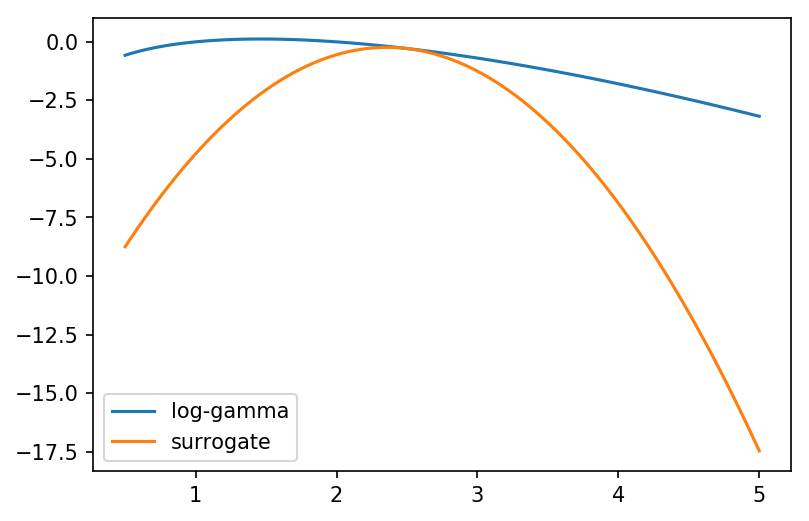

In [24]:
plt.plot(x, -f, label='log-gamma')
plt.plot(x, -g, label='surrogate')
plt.legend()